In [3]:
%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from matplotlib import gridspec

import numpy as np
from numpy import linalg

def add_relative_to_current_source_file_path_to_sys_path(relpath):
    import os, sys, inspect
    path = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile(inspect.currentframe()))[0],relpath)))
    if path not in sys.path:
        sys.path.insert(0,path)

add_relative_to_current_source_file_path_to_sys_path("../../src")   
add_relative_to_current_source_file_path_to_sys_path("../../logs")      

import spooky.coords
import log_graph
import replay.main

/Users/njoubert/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
LOG = "/Users/njoubert/Code/spooky/logs/state0001109.pickle"

'''
Setting up Tableau Colors. 
http://tableaufriction.blogspot.ca/2012/11/finally-you-can-use-tableau-data-colors.html
'''
t10 = np.array([[31,119,180],[255,127,14],[44,160,44],[214,39,40],[148,103,189]])
t10 = t10/255.0

t10l = np.array([[174,199,232],[255,187,120],[152,223,138],[255,152,150],[197,176,213]])
t10l = t10l/255.0

In [5]:
replay.main.generate_fake_SPP_GPS_Baselines

<function replay.main.generate_fake_SPP_GPS_Baselines>

In [6]:
l = log_graph.loadLog(LOG)

In [7]:

replay.main.reset_fake_calib()
for nextState in l:
    replay.main.generate_fake_SPP_GPS_Baselines(nextState,verbose=False)
    

In [8]:
errorNED = []
errorNE  = []
startTime = None
lastTime = 0
for nextState in l:
    if not startTime:
        startTime = nextState["_timestamp"]
    lastTime = nextState["_timestamp"]
    if "base_station" in nextState and "surveyed_pos" in nextState["base_station"]:
        for p in ['192.168.2.51','192.168.2.52']:
            person = nextState[p]
            real_baseline = np.array([float(person["MsgBaselineNED"]['n']), float(person["MsgBaselineNED"]['e']), float(person["MsgBaselineNED"]['d'])])
            calib_rel_ned = np.array([float(person["SPPGPSBaseline_calibrated"]['n']),float(person["SPPGPSBaseline_calibrated"]['e']),float(person["SPPGPSBaseline_calibrated"]['d'])])
            uncalib_rel_ned = np.array([float(person["SPPGPSBaseline"]['n']),float(person["SPPGPSBaseline"]['e']),float(person["SPPGPSBaseline"]['d'])])
            
            localError = linalg.norm(real_baseline - calib_rel_ned)
            errorNED.append([localError])
            localNEError = linalg.norm(real_baseline[0:1] - calib_rel_ned[0:1])
            errorNE.append([localNEError])
print errorNED            

[[0.0], [0.0], [27.923854766729615], [10.277972337694269], [36.793429358992221], [94.030977642850942], [33.889249236336077], [126.69909521805687], [45.165680093900775], [145.64028682140176], [57.553677038087997], [177.98941801270544], [68.597331621879476], [219.09398204571809], [70.639068526749156], [224.96708990012795], [69.732491127991693], [301.46457283501132], [69.732491127991693], [306.59263732897466], [71.229350122793988], [317.07141131980444], [79.928854170014034], [346.65583432109315], [81.65880432000921], [362.46913754345604], [97.98279597602415], [401.29365000375373], [97.722700600370644], [411.84136083315019], [102.1506421809451], [439.63752984964106], [101.04828662051115], [423.08001219588516], [111.38611222106233], [449.94734639068071], [106.42670321178863], [434.64397883397788], [124.25865701920637], [461.39213071080474], [124.91188349845457], [438.12733025687305], [120.79564281965045], [469.5003541274578], [117.48544182666159], [468.06608893669568], [122.72095490398104],

In [9]:
### GLOBAL_POSITION_INT CONTAINS THE RESULTING *FUSED* POSITION.
### THUS, THIS IS USING A NORMAL GPS ASSISTED WITH AN IMU AND BAROMETER

def get_errors_from_log(logname, startTime=0.0, endTime=-1.0):
    l = log_graph.loadLog(logname, startTime=startTime, endTime=endTime)
    replay.main.reset_fake_calib()
    for nextState in l:
        replay.main.generate_fake_SPP_GPS_Baselines(nextState,verbose=False)

    errorNED = []
    errorNE  = []
    calibrated_baselines = []
    real_baselines = []
    
    startTime = None
    lastTime = 0
    for nextState in l:
        if "base_station" in nextState and "surveyed_pos" in nextState["base_station"]:
            if not startTime:
                startTime = nextState["_timestamp"]
            lastTime = nextState["_timestamp"]
            for p in ['192.168.2.51','192.168.2.52']:
                person = nextState[p]
                if "MsgBaselineNED" in person and person["MsgBaselineNED"]["flags"] == 1:
                    
                    real_baseline = np.array([float(person["MsgBaselineNED"]['n']), float(person["MsgBaselineNED"]['e']), float(person["MsgBaselineNED"]['d'])])
                    calib_rel_ned = np.array([float(person["SPPGPSBaseline_calibrated"]['n']),float(person["SPPGPSBaseline_calibrated"]['e']),float(person["SPPGPSBaseline_calibrated"]['d'])])
                    uncalib_rel_ned = np.array([float(person["SPPGPSBaseline"]['n']),float(person["SPPGPSBaseline"]['e']),float(person["SPPGPSBaseline"]['d'])])

                    real_baseline = real_baseline / 1000.0
                    calib_rel_ned = calib_rel_ned / 1000.0
                    
                    calibrated_baselines.append(calib_rel_ned)
                    real_baselines.append(real_baseline)
                    
                    localError = linalg.norm(real_baseline - calib_rel_ned)
                    errorNED.append([localError])
                    localNEError = linalg.norm(real_baseline[0:1] - calib_rel_ned[0:1])
                    errorNE.append([localNEError])
    return errorNE, errorNED, calibrated_baselines, real_baselines, lastTime - startTime 

In [10]:
errorNE, errorNED, calib_baselines, real_baselines, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001103.pickle", startTime=1, endTime=500)

numbins = 20

worldspace_n, worldspace_bins = np.histogram(errorNED, bins=numbins, normed=False, range=(0, 5))
worldspace_n = worldspace_n / float(len(errorNED)) * 100

import json

json_data=open("replay_516_14.json").read()

data = json.loads(json_data)

screenError = []
for d in data:
    screenError.append(linalg.norm(np.array(d['players'][0]['screen']) - np.array(d['ghostPlayers'][0]['screen'])))
    screenError.append(linalg.norm(np.array(d['players'][1]['screen']) - np.array(d['ghostPlayers'][1]['screen'])))
    

    screenspace_n, screenspace_bins = np.histogram(screenError, bins=numbins, range=(0, 1))
screenspace_n = screenspace_n / float(len(screenError)) * 100

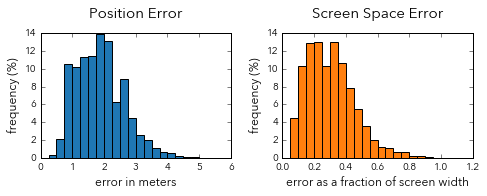

In [27]:

#################### THESIS FIGURE

# Had to install Avenir Next as matplotlib font:
# http://blog.olgabotvinnik.com/blog/2012/11/15/2012-11-15-how-to-set-helvetica-as-the-default-sans-serif-font-in/
# https://onlinefontconverter.com/

pylab.rcParams['figure.figsize'] = 7, 3
matplotlib.rcParams['font.sans-serif'] = "Avenir Next"
matplotlib.rcParams['font.family'] = "sans-serif"


matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10

gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1]) 


#################### PAPER FIGURE

# pylab.rcParams['figure.figsize'] = 4.5, 6
# matplotlib.rcParams.update({'font.size': 12})
# plt.rc('font', family='serif')
# gs = gridspec.GridSpec(2, 1, width_ratios=[1], height_ratios=[1,1]) 

####################


fig = plt.figure()

# fig.suptitle("", fontsize=18)

f1 = fig.add_subplot(gs[0])
f2 = fig.add_subplot(gs[1])


# WORLD SPACE ERROR
rects1 = f1.bar(worldspace_bins[1:51], worldspace_n, 0.25, color=t10[0])
f1.set_title('Position Error', y=1.08, fontsize=15)
f1.set_xlabel('error in meters', fontsize=12)
f1.set_ylabel('frequency (%)', fontsize=12)


# SCREEN SPACE ERROR
rects1 = f2.bar(screenspace_bins[1:51], screenspace_n, 0.05, color=t10[1])
f2.set_title('Screen Space Error', y=1.08, fontsize=15)
f2.set_xlabel('error as a fraction of screen width', fontsize=12)
f2.set_ylabel('frequency (%)', fontsize=12)


fig.tight_layout()
pylab.savefig("GPS_Error.pdf")


In [1]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

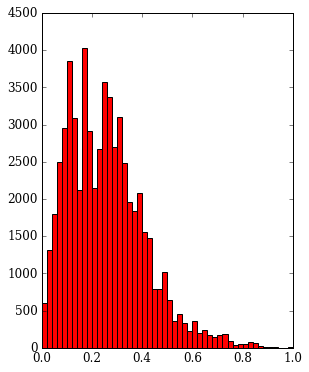

In [226]:


fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.02, color='r')


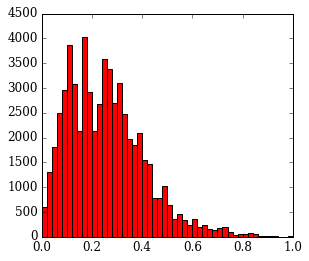

In [90]:
loglist = [
    "/Users/njoubert/Code/spooky/logs/state0001091.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001094.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001099.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001101.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001102.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001103.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001105.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001106.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001109.pickle",
    "/Users/njoubert/Code/spooky/logs/state0001110.pickle"
]

[0.0]
[0.0]
51
1000.54448318


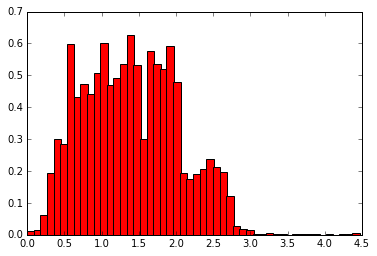

In [91]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001091.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=True)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
686.890803099


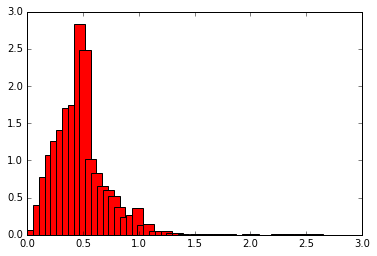

In [75]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001094.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=True)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
837.866279125


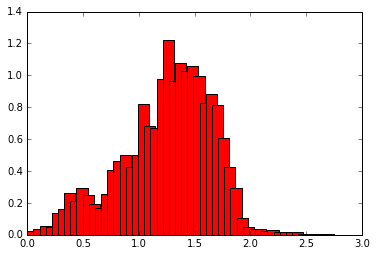

In [76]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001099.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=True)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

13246
13246
51


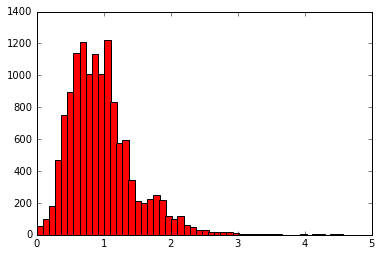

[0.0]
[0.0]
51
30.9852809906


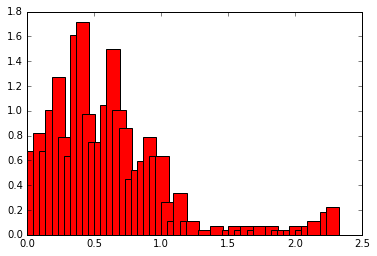

In [78]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001102.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=True)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
524.055351973


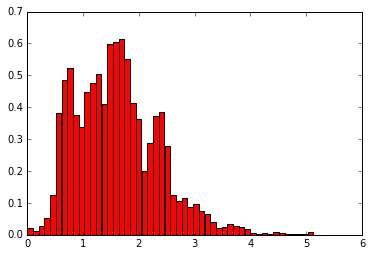

In [79]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001103.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=True)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
524.055351973


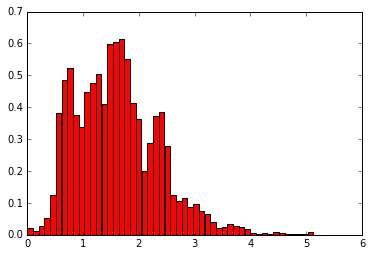

In [80]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001103.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=True)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
616.489763975


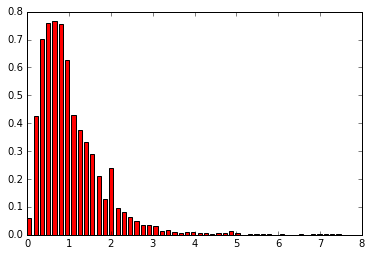

In [81]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001105.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=True)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
1158.86017394


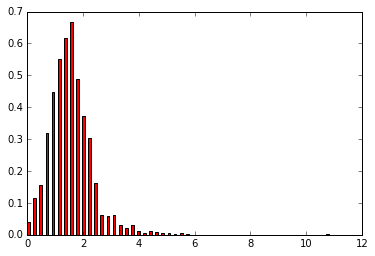

In [82]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001106.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=True)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

[0.0]
[0.0]
51
215.528002977
215.528002977


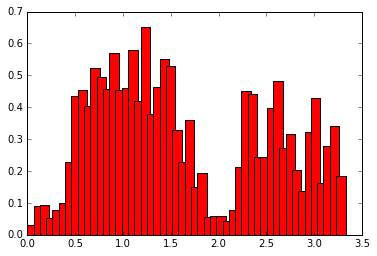

In [83]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001109.pickle")

print errorNED[0]
print errorNE[0]
n, bins = np.histogram(errorNED, bins=50, density=True)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength
print loglength

7845
7845
51
418.229232073


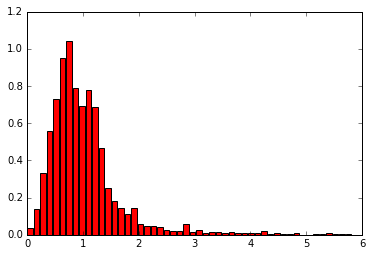

In [84]:
errorNE, errorNED, loglength = get_errors_from_log("/Users/njoubert/Code/spooky/logs/state0001110.pickle")

print len(errorNED)
print len(errorNE)
n, bins = np.histogram(errorNED, bins=50, density=True)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
print loglength

In [85]:
logresults = []
for l in loglist:
    errorNE, errorNED, loglength = get_errors_from_log(l)
    logresults.append((errorNE,errorNED,loglength))

In [86]:
errorNE  = []
errorNED = []
for r in logresults:
    errorNE = errorNE + r[0]
    errorNED = errorNED + r[1]
    print r[2]

1000.54448318
686.890803099
837.866279125
748.320538044
30.9852809906
524.055351973
616.489763975
1158.86017394
215.528002977
418.229232073


115469
115469
51


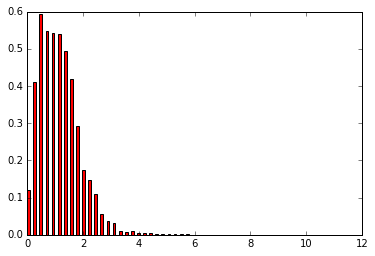

In [87]:
# Relative error across ALL 10 capture sessions.

print len(errorNED)
print len(errorNE)
n, bins = np.histogram(errorNED, bins=50, density=True)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')

51


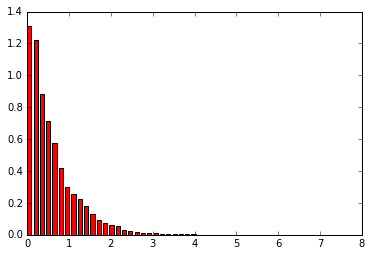

In [88]:
n, bins = np.histogram(errorNE, bins=50, density=True)

print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 0.1, color='r')
